In [3]:
from sklearn import datasets
import numpy as np

In [4]:
iris = datasets.load_iris()


In [5]:
X = iris.data[:, [2, 3]]
y = iris.target
print('Метки классов: ', np.unique(y))

Метки классов:  [0 1 2]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
print('Кoличество меток в у: ', np.bincount(y))

Кoличество меток в у:  [50 50 50]


In [8]:
print('Кoличество меток в у: ', np.bincount(y_train))

Кoличество меток в у:  [35 35 35]


In [9]:
print('Кoличество меток в у: ', np.bincount(y_test))

Кoличество меток в у:  [15 15 15]


In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [11]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [12]:
y_pred = ppn.predict(X_test_std)
print('Неправильно классифицированных образцов: %d' % (y_test != y_pred).sum())


Неправильно классифицированных образцов: 1


In [13]:
from sklearn.metrics import accuracy_score
print('Правильность: %.3f' % accuracy_score(y_test, y_pred))

Правильность: 0.978


In [14]:
print('Правильность: %.3f' % ppn.score(X_test_std, y_test))

Правильность: 0.978


In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, 
                          test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=cl,
                   edgecolor='black')
        if test_idx:
            X_test, y_test = X[test_idx, :], y[test_idx]
            plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
                       alpha=1.0, linewidth=1, marker='o', s=100,
                       label='испытательный набор')

<ipython-input-15-be3b7048943a>:25: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',


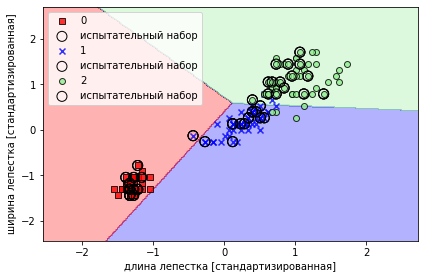

In [16]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, 
                      test_idx=range(105, 150))
plt.xlabel('длина лепестка [стандартизированная]')
plt.ylabel('ширина лепестка [стандартизированная]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


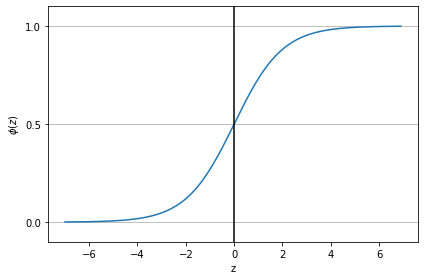

In [18]:
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

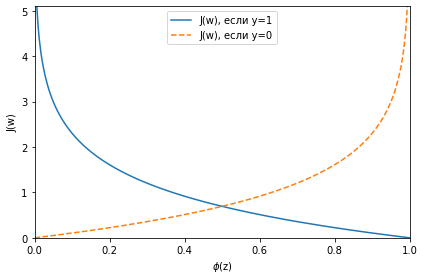

In [19]:
import numpy as np
def cost_1(z):
    return - np.log(sigmoid(z))
def cost_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w), если y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w), если y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [26]:
class LogisticRegressionGD(object):
    '''Классификатор на основе 
    логистической регрессии, использующий
    градиентный спуск
    Параметры
    _________
    eta : float
        Скорость обучения (между 0.0 и 1.0)
    n_iter : int
        Проходы по обучающему набору данных
    random_state : int
        Начальное значение генератора случайных чисел
        для инициализации случайными весами.
    Атрибуты
    ________
    w_ : одномерный массив
        Веса после подгонки
    cost_ : list
        Значение логистической функции издержек в каждой эпохе.
    '''
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        '''Подгоняет к обучающим данным.
        Параметры
        _________
        X : {подобен массиву}, форма = [n_examples, n_features]
            Обучающие векторы, где n_examples - количество образцов,
            n_features - количество признаков
        y : подобен массиву, форма = [n_examples]
            Целевые значения
        Возвращает
        __________
        self : object
        '''
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        '''
        Вычисляет общий вход
        '''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        '''Вычисялет логистическую сигмоидальную активацию'''
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        '''
        Возвращает метку класса  после единичного шага
        '''
        return np.where(self.net_input(X) >= 0.0, 1, 0)

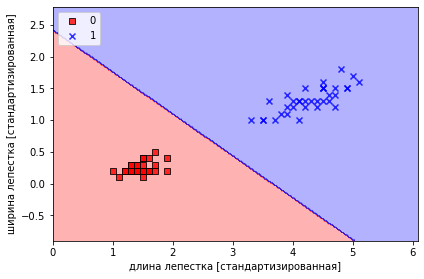

In [27]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=100, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('длина лепестка [стандартизированная]')
plt.ylabel('ширина лепестка [стандартизированная]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()